In [1]:
import os
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPooling2D, Flatten,Conv2D,Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import losses
from tensorflow.keras.metrics import Recall, Precision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
import sys
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import  preprocess_input
from keras.utils import to_categorical
import os
import cv2 as cv
from sklearn.metrics import roc_auc_score

In [2]:
train_dir = r"C:\University\6th semester\machine_learning\FaceSplittednew\train"
test_dir =  r"C:\University\6th semester\machine_learning\FaceSplittednew\test"
# Set up the image dimensions
img_height = 224
img_width = 224

 

# Define a function to preprocess the images
def preprocess_images(data_dir):
    X = []
    y = []
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.jpg'):
                    img_path = os.path.join(class_dir, file_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_height, img_width))
                    img= img_to_array(img)
                    img=preprocess_input(img)
                    X.append(img)
                    y.append(class_name)
                    
    X = np.array(X)
    y = np.array(y)
    
    # Normalize the data using mean and standard deviation and we applied the normalization before the oversamling to prevent data leakage
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(X.shape[0], -1))
    X = X.reshape(-1, img_height, img_width, 3)
    
   
    
    
    # Perform label encoding on the target variable (labels)
#     label_encoder = LabelEncoder()
#     y_resampled = label_encoder.fit_transform(y_resampled)
    
    return X, y



In [3]:
# Preprocess the training data
train_X, train_y = preprocess_images(train_dir)

# Preprocess the testing data
test_X, test_y = preprocess_images(test_dir)

In [4]:
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

In [5]:
train_y_encoded.shape

(1633,)

In [6]:
ct=0
ct1=0
for i in range(len(train_y_encoded)):
    if train_y_encoded[i]==1:
        ct1+=1#real
    else:
        ct+=1#fake
print(f"real:{ct1},fake:{ct}")

real:865,fake:768


In [7]:
augImg=[]
augLabel=[]
for i in range(97):        
    flipped_img = cv.flip(train_X[i],0)
    augImg.append(flipped_img)
    augLabel.append(train_y_encoded[i])
new_images = np.array(augImg)
train_X= np.concatenate([train_X,new_images])
train_y_encoded= np.concatenate([train_y_encoded,augLabel])

In [8]:
train_y_encoded.shape

(1730,)

In [9]:
ct=0
ct1=0
for i in range(len(train_y_encoded)):
    if train_y_encoded[i]==1:
        ct1+=1#real
    else:
        ct+=1#fake
print(f"real:{ct1},fake:{ct}")

real:865,fake:865


In [10]:
print("the trainX shape is:",train_X.shape)
print("the testx shape is",test_X.shape)
print("the ytrain shape is:",train_y.shape)
print("the ytest shape is:",test_y.shape)

the trainX shape is: (1730, 224, 224, 3)
the testx shape is (408, 224, 224, 3)
the ytrain shape is: (1633,)
the ytest shape is: (408,)


In [11]:
ct=0
ct1=0
for i in range(len(test_y_encoded)):
    if test_y_encoded[i]==1:
        ct1+=1
    else:
        ct+=1
print(f"real:{ct1},fake:{ct}")

real:216,fake:192


In [12]:
# Load the ResNet50 model without the top classification layer
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [13]:
#This will set all layers in the ResNet50 model to be untrainable so that their weights will not be updated during training.
for layer in vgg16_model.layers:
    layer.trainable = False

In [17]:
#fine tune the way u desire
headModel = vgg16_model.output
headModel = Flatten()(headModel)
headModel = Dense(1080, activation='relu')(headModel)
head_model = Dropout(0.3)(headModel)
headModel = Dense(512, activation='relu')(headModel)
head_model = Dropout(0.3)(headModel)
headModel = Dense(128, activation='relu')(headModel)
head_model = Dropout(0.3)(headModel)
headModel = Dense(1, activation='sigmoid')(headModel)

In [18]:
model=Model(inputs=vgg16_model.input, outputs=headModel)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

In [21]:
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics)

In [22]:
train_y_encoded

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
with tf.device('/device:CPU:0'):
    #khalena elepochs w el batches w el optimizer zy b3dena
    history = model.fit(train_X,train_y_encoded,batch_size=64 ,epochs=10,
                            validation_data=(test_X, test_y_encoded))

Epoch 1/10
28/28 [==============================] - 108s 4s/step - loss: 1.3587 - accuracy: 0.5179 - precision: 0.5181 - recall: 0.5133 - val_loss: 0.8519 - val_accuracy: 0.4902 - val_precision: 0.7500 - val_recall: 0.0556
Epoch 2/10
28/28 [==============================] - 111s 4s/step - loss: 0.6754 - accuracy: 0.6434 - precision: 0.6578 - recall: 0.5977 - val_loss: 0.7357 - val_accuracy: 0.5858 - val_precision: 0.7582 - val_recall: 0.3194
Epoch 3/10
28/28 [==============================] - 111s 4s/step - loss: 0.4799 - accuracy: 0.7578 - precision: 0.7563 - recall: 0.7607 - val_loss: 0.7245 - val_accuracy: 0.5980 - val_precision: 0.6566 - val_recall: 0.5046
Epoch 4/10
28/28 [==============================] - 112s 4s/step - loss: 0.3558 - accuracy: 0.8503 - precision: 0.8435 - recall: 0.8601 - val_loss: 1.2124 - val_accuracy: 0.5711 - val_precision: 0.5535 - val_recall: 0.9815
Epoch 5/10
28/28 [==============================] - 112s 4s/step - loss: 0.3070 - accuracy: 0.8630 - precisi

In [24]:
with tf.device('/device:CPU:0'):
    y_pred = model.predict(test_X)

13/13 [==============================] - 21s 2s/step


In [25]:
# Convert the predicted probabilities to class labels
threshold = 0.5

y_pred_classes = np.where(y_pred >= threshold, 1, 0)

conf_mat = confusion_matrix(test_y_encoded, y_pred_classes)

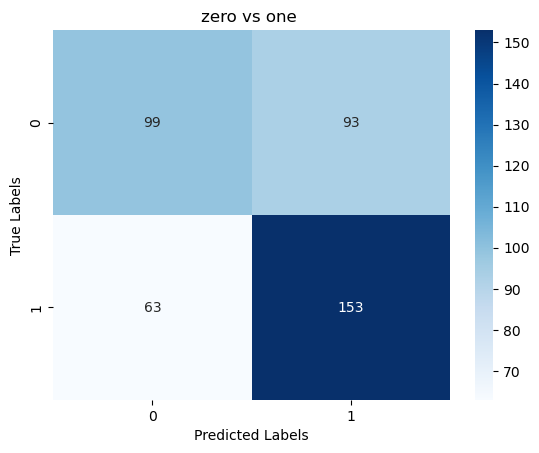

In [26]:
# Compute the confusion matrix
cm = confusion_matrix(test_y_encoded, y_pred_classes)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues",fmt='g')

# Add labels and title to the plot
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("zero vs one ")

# Show the plot
plt.show()

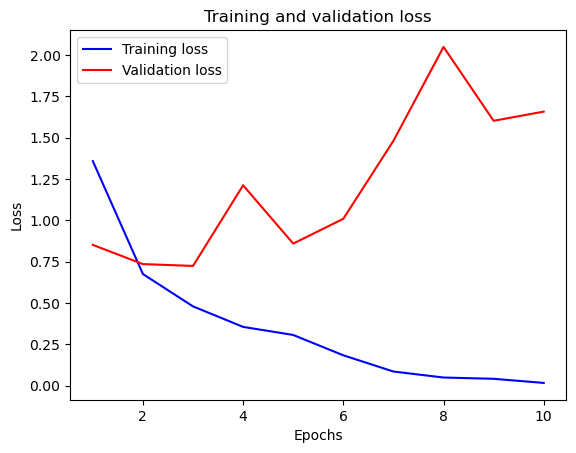

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

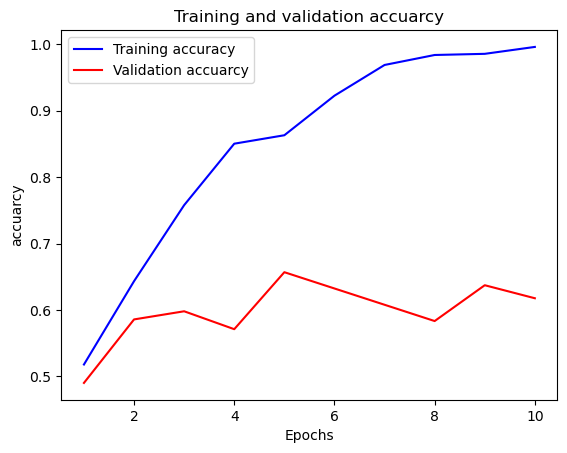

In [28]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation accuarcy')
plt.title('Training and validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('accuarcy')
plt.legend()

plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

# assume y_true and y_pred are the ground truth and predicted labels respectively
# for a multi-class classification problem with classes 0 to n-1
cm = confusion_matrix(test_y_encoded, y_pred_classes)
report = classification_report(test_y_encoded, y_pred_classes)

# recall for each class can be obtained from the classification report
print(report)

              precision    recall  f1-score   support

           0       0.61      0.52      0.56       192
           1       0.62      0.71      0.66       216

    accuracy                           0.62       408
   macro avg       0.62      0.61      0.61       408
weighted avg       0.62      0.62      0.61       408



In [30]:
# calculate AUC score
auc_score = roc_auc_score(test_y_encoded, y_pred_classes)

# print the AUC score
print("AUC score: {:.2f}".format(auc_score))

AUC score: 0.61
